In [1]:
import os
import cv2
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [2]:
import os
from zipfile import ZipFile


!pip install kaggle


os.environ['KAGGLE_USERNAME'] = "parthhtrp"
os.environ['KAGGLE_KEY'] = "3c61ded81cf3887193f7a9ed32ce52b5"


!kaggle datasets download -d jessicali9530/lfw-dataset


with ZipFile('lfw-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('lfw-dataset')


os.remove('lfw-dataset.zip')


100% 112M/112M [00:04<00:00, 31.2MB/s]
100% 112M/112M [00:04<00:00, 24.9MB/s]


In [3]:
import os

dataset_path = 'lfw-dataset'

# List all directories in the dataset folder
folders = [name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))]

# Print the number of folders
print("Number of folders in the dataset:", len(folders))


Number of folders in the dataset: 1


In [ ]:
import os

def print_folder_contents(folder_path, indent=''):
    # List all directories and files in the folder
    contents = os.listdir(folder_path)

    for item in contents:
        item_path = os.path.join(folder_path, item)

        # Check if the item is a directory
        if os.path.isdir(item_path):
            print(indent + "Folder:", item)
            print_folder_contents(item_path, indent + '  ')
        else:
            print(indent + "File:", item)

dataset_path = 'lfw-dataset'
x=0

# List all directories in the dataset folder
folders = [name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))]

# Print number of folders
print("Number of folders in the dataset:", len(folders))

# Print details of each folder
for folder in folders:
    print("\nFolder:", folder)
    print_folder_contents(os.path.join(dataset_path, folder))





Streaming output truncated to the last 5000 lines.
  Folder: Hisashi_Owada
    File: Hisashi_Owada_0001.jpg
  Folder: Amanda_Coetzer
    File: Amanda_Coetzer_0002.jpg
    File: Amanda_Coetzer_0001.jpg
  Folder: Carla_Tricoli
    File: Carla_Tricoli_0001.jpg
  Folder: Akmal_Taher
    File: Akmal_Taher_0001.jpg
  Folder: Wendell_Bryant
    File: Wendell_Bryant_0001.jpg
  Folder: George_Galloway
    File: George_Galloway_0003.jpg
    File: George_Galloway_0002.jpg
    File: George_Galloway_0004.jpg
    File: George_Galloway_0001.jpg
  Folder: Mireya_Elisa_Moscoso_Rodriguez
    File: Mireya_Elisa_Moscoso_Rodriguez_0001.jpg
  Folder: Dick_Latessa
    File: Dick_Latessa_0001.jpg
    File: Dick_Latessa_0002.jpg
  Folder: Paul_Patton
    File: Paul_Patton_0001.jpg
    File: Paul_Patton_0002.jpg
  Folder: Kurt_Busch
    File: Kurt_Busch_0002.jpg
    File: Kurt_Busch_0001.jpg
  Folder: Kit_Bond
    File: Kit_Bond_0001.jpg
  Folder: Hermes_Gamonal
    File: Hermes_Gamonal_0001.jpg
  Folder: Lydia

In [ ]:
import os

def count_folders_and_images(folder_path):
    num_folders = 0
    num_images = 0

    # List all items (files and directories) in the folder
    items = os.listdir(folder_path)

    for item in items:
        item_path = os.path.join(folder_path, item)
        # Check if the item is a directory
        if os.path.isdir(item_path):
            num_folders += 1
        else:
            num_images += 1

    return num_folders, num_images

def print_folder_contents(folder_path, indent=''):
    # List all directories in the folder
    subfolders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

    for subfolder in subfolders:
        print(indent + "Subfolder:", subfolder)
        num_folders, num_images = count_folders_and_images(os.path.join(folder_path, subfolder))
        print(indent + "Number of folders:", num_folders)
        print(indent + "Number of images:", num_images)

dataset_path = 'lfw-dataset'

# List all directories in the dataset folder
folders = [name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))]

# Print number of folders
print("Number of folders in the dataset:", len(folders))

# Print details of each folder
for folder in folders:
    print("\nFolder:", folder)
    num_folders, num_images = count_folders_and_images(os.path.join(dataset_path, folder))
    print("Number of folders:", num_folders)
    print("Number of images:", num_images)
    print_folder_contents(os.path.join(dataset_path, folder), '  ')


Number of folders in the dataset: 1

Folder: lfw-deepfunneled
Number of folders: 1
Number of images: 0
  Subfolder: lfw-deepfunneled
  Number of folders: 5749
  Number of images: 0


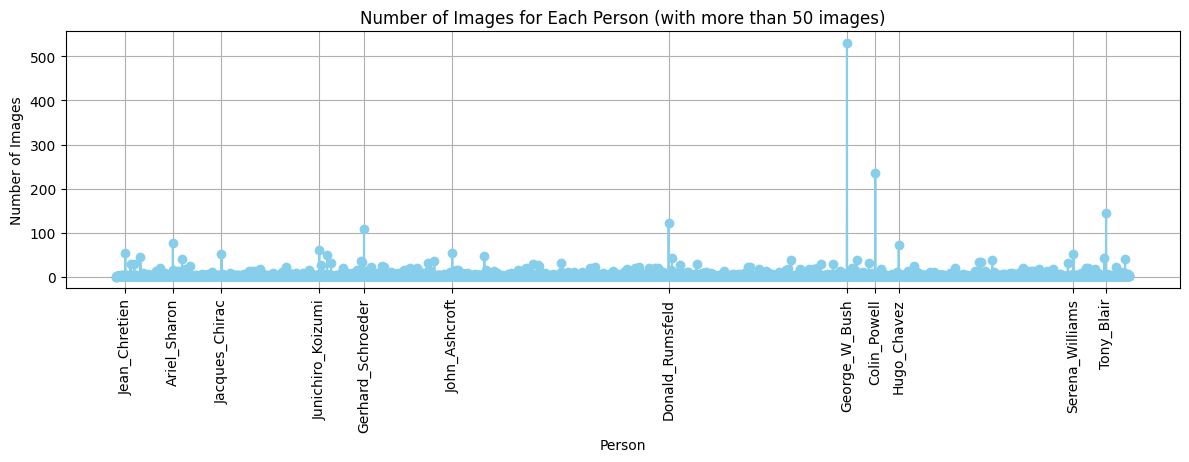

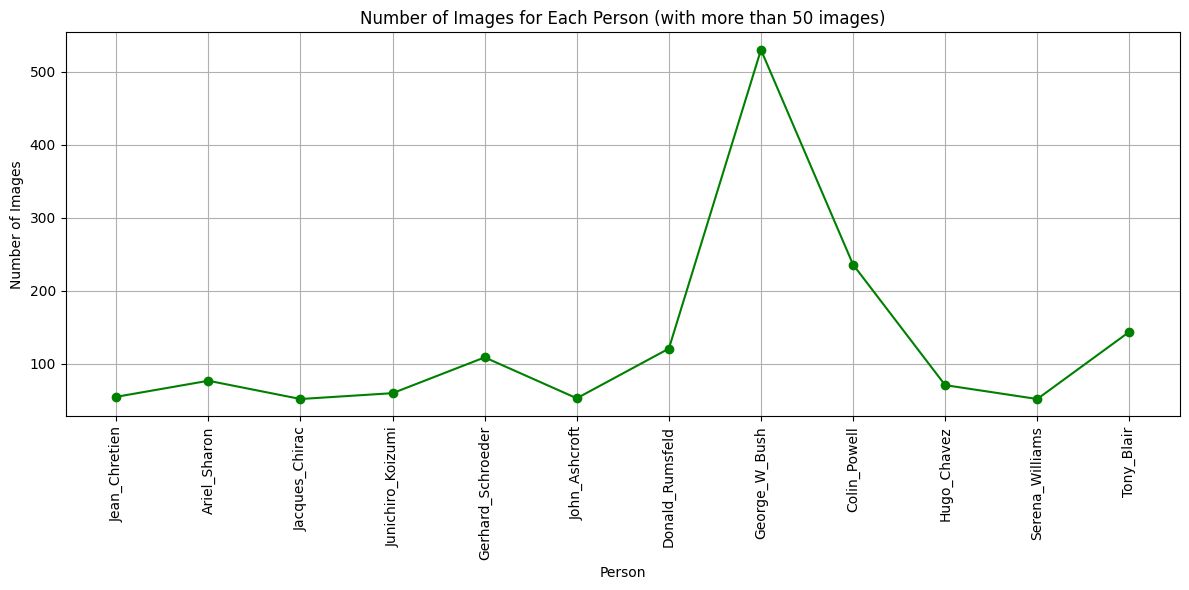

In [ ]:
import os
import matplotlib.pyplot as plt

def count_images_in_folder(folder_path):
    # Initialize the count
    count = 0

    # List all items (files and directories) in the folder
    items = os.listdir(folder_path)

    # Check each item in the folder
    for item in items:
        item_path = os.path.join(folder_path, item)

        # If the item is a directory, recursively count images in it
        if os.path.isdir(item_path):
            count += count_images_in_folder(item_path)
        else:
            # If the item is a file and ends with a supported image extension, increment the count
            if any(item.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']):
                count += 1

    return count

def count_images_per_person(dataset_path):
    # Initialize lists to store person names and their corresponding image counts
    person_names = []
    num_images = []

    # Iterate over all directories in the dataset
    for root, dirs, files in os.walk(dataset_path):
        # Check if the current directory contains image files
        image_count = sum(1 for file in files if any(file.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']))

        # Add the directory name (person name) and image count to the lists
        person_names.append(os.path.basename(root))
        num_images.append(image_count)

    return person_names, num_images

dataset_path = 'lfw-dataset'

person_names, num_images = count_images_per_person(dataset_path)

# Filter person names and corresponding image counts
person_names_filtered = [person_names[i] for i in range(len(person_names)) if num_images[i] > 50]
num_images_filtered = [num_images[i] for i in range(len(person_names)) if num_images[i] > 50]

# Plot graph for all people with image count > 50
plt.figure(figsize=(12, 6))
plt.plot(person_names, num_images, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Person (with more than 50 images)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()

# Show only names of people with image count > 50
plt.xticks(person_names_filtered)

plt.show()
# Plot graph for people with image count greater than 50
person_names_filtered = [person_names[i] for i in range(len(person_names)) if num_images[i] > 50]
num_images_filtered = [num_images[i] for i in range(len(person_names)) if num_images[i] > 50]

plt.figure(figsize=(12, 6))
plt.plot(person_names_filtered, num_images_filtered, marker='o', color='green', linestyle='-')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Person (with more than 50 images)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()

plt.show()


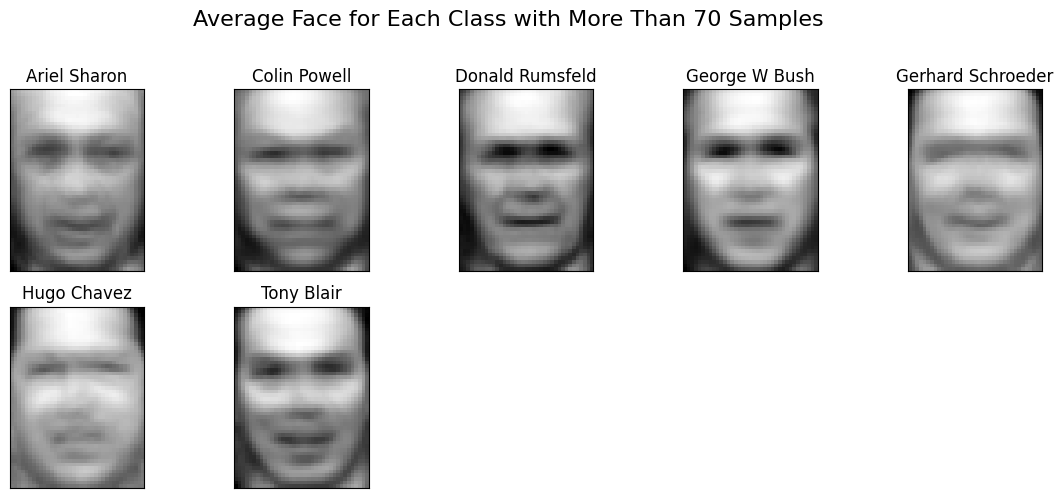

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)

# Extracting data and target labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_samples, n_features = X.shape
n_classes = len(target_names)

# Count the number of samples per class
samples_per_class = np.bincount(y)

# Filter classes with more than 70 samples
classes_greater_than_70 = np.where(samples_per_class > 70)[0]

# Plotting the average face for each class with more than 70 samples
plt.figure(figsize=(14, 8))
for i in range(min(len(classes_greater_than_70), 15)):
    class_idx = classes_greater_than_70[i]
    class_images = X[y == class_idx]
    average_face = np.mean(class_images, axis=0)
    plt.subplot(3, 5, i + 1)
    plt.imshow(average_face.reshape((lfw_people.images.shape[1], lfw_people.images.shape[2])), cmap=plt.cm.gray)
    plt.title(target_names[class_idx])
    plt.xticks(())
    plt.yticks(())

plt.suptitle("Average Face for Each Class with More Than 70 Samples", size=16)
plt.show()


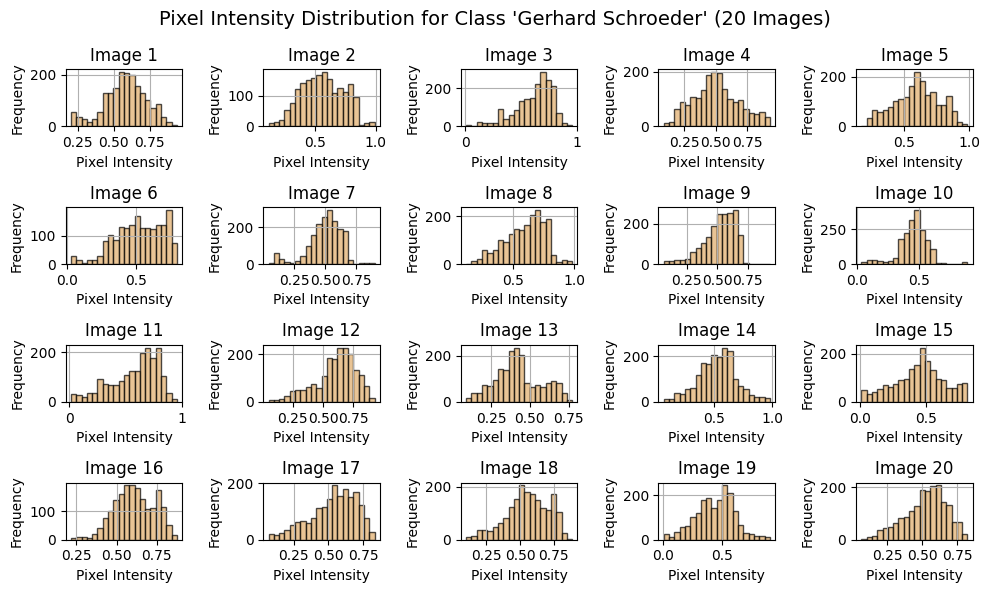

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

target_names = lfw_people.target_names
n_samples, n_features = X.shape
n_classes = len(target_names)

# We will choose a specific class for histogram visualization
class_index = 5  # You can change this to visualize other classes
class_images = X[y == class_index][:20]  # Select 20 images from the class for histogram visualization

# Defining a specific colour for noce presentation
skin_color = '#E0AC69'  # HEX color code

# Plotting histograms to visualize pixel intensity distribution for 20 images of a specific class
plt.figure(figsize=(10, 6))
for i in range(len(class_images)):
    plt.subplot(4, 5, i + 1)
    plt.hist(class_images[i], bins=20, edgecolor='black', alpha=0.7, color=skin_color)
    plt.title(f"Image {i + 1}")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.suptitle(f"Pixel Intensity Distribution for Class '{target_names[class_index]}' (20 Images)", size=14)
plt.tight_layout()
plt.show()


In [30]:
# Printing the total number of features
total_features = X.shape[1]
print(f"Total number of features: {total_features}")


Total number of features: 1850


<ipython-input-28-acf055f7c718>:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[class_indices, i], X[class_indices, j], marker=marker, s=size, c=color, alpha=0.5, label=f'Class {class_label}')


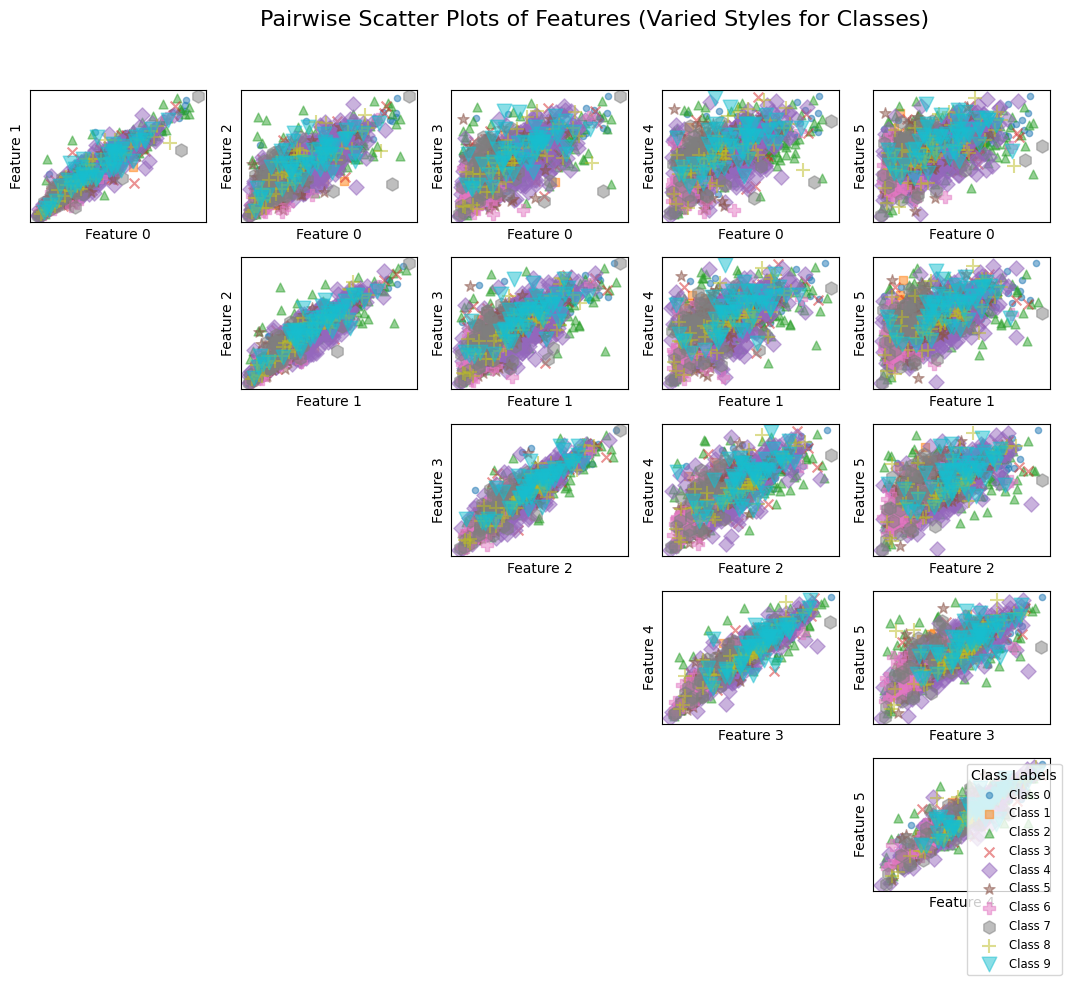

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

# Get unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)

# Define markers, colors, and sizes for each class
markers = ['o', 's', '^', 'x', 'D', '*', 'P', 'h', '+', 'v']
colors = plt.cm.tab10.colors[:len(unique_classes)]
sizes = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

plt.figure(figsize=(12, 10))

# Plotting pairwise scatter plots with varied styles for each class
for i in range(5):
    for j in range(i+1, 6):
        ax = plt.subplot(5, 5, i*5 + j)
        for class_label, marker, color, size in zip(unique_classes, markers, colors, sizes):
            class_indices = np.where(y == class_label)[0]
            ax.scatter(X[class_indices, i], X[class_indices, j], marker=marker, s=size, c=color, alpha=0.5, label=f'Class {class_label}')
        ax.set_xlabel(f'Feature {i}')
        ax.set_ylabel(f'Feature {j}')
        ax.set_xticks(())
        ax.set_yticks(())

# Place the legend outside the subplots
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize='small', title='Class Labels', title_fontsize='medium')

plt.suptitle('Pairwise Scatter Plots of Features (Varied Styles for Classes)', size=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the layout to accommodate the legend
plt.show()


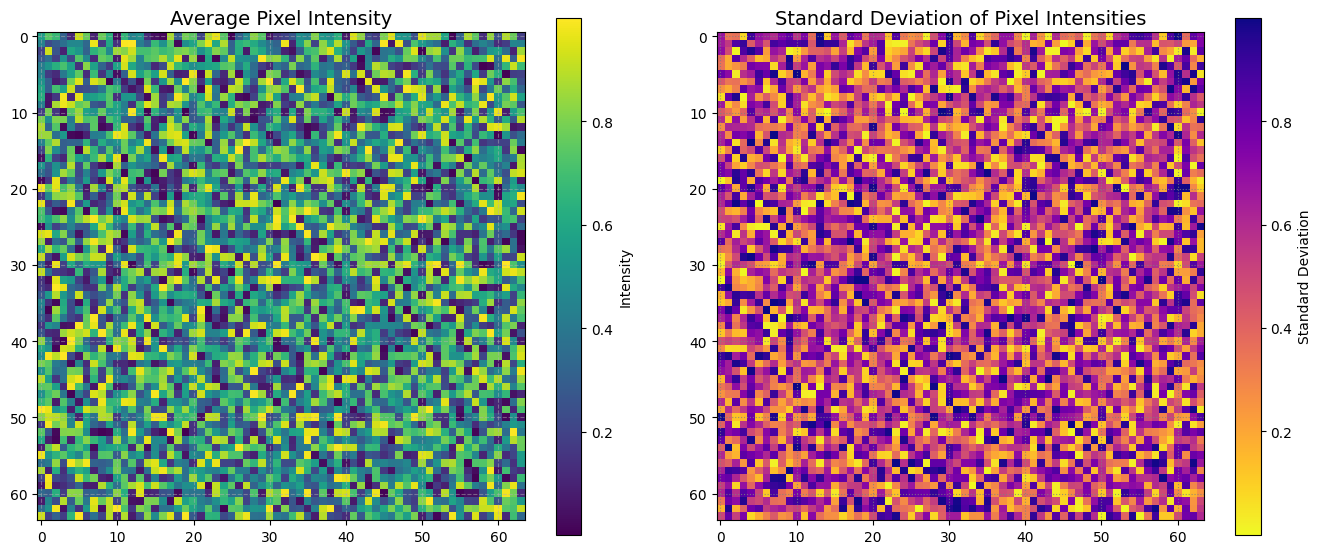

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data for demonstration
average_intensity = np.random.rand(64, 64)
std_intensity = np.random.rand(64, 64)

# Plotting average pixel intensity and standard deviation side by side with different styles
plt.figure(figsize=(14, 6))

# Plotting average pixel intensity with a custom colormap
plt.subplot(1, 2, 1)
plt.imshow(average_intensity, cmap='viridis')
plt.title('Average Pixel Intensity', fontsize=14)
plt.colorbar(label='Intensity')
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting standard deviation of pixel intensities with a reversed colormap
plt.subplot(1, 2, 2)
plt.imshow(std_intensity, cmap='plasma_r')  # Use 'plasma_r' colormap with reversed colors
plt.title('Standard Deviation of Pixel Intensities', fontsize=14)
plt.colorbar(label='Standard Deviation')
plt.grid(True, linestyle=':', alpha=0.8, color='gray')  # Add grid lines with different style and color

plt.tight_layout(pad=3.0)
plt.show()


In [ ]:

def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    features = features.squeeze(0)
    return features


def compute_hog(img):
    resized_img = resize(img, (128*4, 64*4))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd


def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))
    val_ar.append(get_pixel(img, center, x, y+1))
    val_ar.append(get_pixel(img, center, x+1, y+1))
    val_ar.append(get_pixel(img, center, x+1, y))
    val_ar.append(get_pixel(img, center, x+1, y-1))
    val_ar.append(get_pixel(img, center, x, y-1))
    val_ar.append(get_pixel(img, center, x-1, y-1))
    val_ar.append(get_pixel(img, center, x-1, y))

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp.flatten()


In [ ]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
lfw_folder = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                hog_feature = compute_hog(image)
                lbp_feature = calcLBP(image)
                cnn_feature = extract_features(image_path, resnet).numpy()
                hog_feature = hog_feature.reshape(-1)
                lbp_feature = lbp_feature.reshape(-1)
                cnn_feature = cnn_feature.flatten()
                combined_feature = np.concatenate((hog_feature, lbp_feature, cnn_feature))

                X.append(combined_feature)
                y.append(folder_name)


<ipython-input-3-8d0f7df1f55f>:19: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)



In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_encoded)
y_pred_knn = knn_clf.predict(X_test)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)
print("KNN Classifier")
print("Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_knn, target_names=label_encoder.classes_))


KNN Classifier
Accuracy: 0.3798449612403101
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.25      0.12      0.17        16
     Colin_Powell       0.30      0.45      0.36        38
  Donald_Rumsfeld       0.29      0.19      0.23        26
    George_W_Bush       0.47      0.61      0.53       109
Gerhard_Schroeder       0.06      0.06      0.06        18
      Hugo_Chavez       0.33      0.05      0.08        21
       Tony_Blair       0.36      0.17      0.23        30

         accuracy                           0.38       258
        macro avg       0.29      0.24      0.24       258
     weighted avg       0.36      0.38      0.35       258



In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_pca, y_train_encoded)
y_pred_knn = knn_clf.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)

print("KNN Classifier")
print("Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_knn, target_names=label_encoder.classes_))

KNN Classifier
Accuracy: 0.3875968992248062
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.09      0.06      0.07        16
     Colin_Powell       0.32      0.47      0.38        38
  Donald_Rumsfeld       0.19      0.15      0.17        26
    George_W_Bush       0.52      0.68      0.59       109
Gerhard_Schroeder       0.17      0.11      0.13        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       0.08      0.03      0.05        30

         accuracy                           0.39       258
        macro avg       0.19      0.22      0.20       258
     weighted avg       0.31      0.39      0.34       258



In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train_encoded)
y_pred_svm = svm_clf.predict(X_test)
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
print("SVM Classifier")
print("Accuracy:", accuracy_svm)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_))


SVM Classifier
Accuracy: 0.4263565891472868
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        16
     Colin_Powell       0.38      0.34      0.36        38
  Donald_Rumsfeld       0.00      0.00      0.00        26
    George_W_Bush       0.43      0.89      0.58       109
Gerhard_Schroeder       0.00      0.00      0.00        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       0.00      0.00      0.00        30

         accuracy                           0.43       258
        macro avg       0.12      0.18      0.13       258
     weighted avg       0.24      0.43      0.30       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train_pca, y_train_encoded)
y_pred_svm = svm_clf.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
print("SVM Classifier")
print("Accuracy:", accuracy_svm)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_))


SVM Classifier
Accuracy: 0.4263565891472868
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        16
     Colin_Powell       0.36      0.37      0.36        38
  Donald_Rumsfeld       0.67      0.08      0.14        26
    George_W_Bush       0.44      0.86      0.58       109
Gerhard_Schroeder       0.00      0.00      0.00        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       0.00      0.00      0.00        30

         accuracy                           0.43       258
        macro avg       0.21      0.19      0.15       258
     weighted avg       0.30      0.43      0.31       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_train, y_train_encoded)
y_pred_adaboost = adaboost_clf.predict(X_test)
accuracy_adaboost = accuracy_score(y_test_encoded, y_pred_adaboost)

print("AdaBoost Classifier")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_adaboost, target_names=label_encoder.classes_))


AdaBoost Classifier
Accuracy: 0.49224806201550386
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        16
     Colin_Powell       0.43      0.47      0.45        38
  Donald_Rumsfeld       0.00      0.00      0.00        26
    George_W_Bush       0.53      0.85      0.65       109
Gerhard_Schroeder       0.83      0.28      0.42        18
      Hugo_Chavez       0.23      0.24      0.23        21
       Tony_Blair       0.55      0.20      0.29        30

         accuracy                           0.49       258
        macro avg       0.37      0.29      0.29       258
     weighted avg       0.43      0.49      0.43       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_train_pca, y_train_encoded)
y_pred_adaboost = adaboost_clf.predict(X_test_pca)
accuracy_adaboost = accuracy_score(y_test_encoded, y_pred_adaboost)

print("AdaBoost Classifier")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_adaboost, target_names=label_encoder.classes_))


AdaBoost Classifier
Accuracy: 0.32170542635658916
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

     Ariel_Sharon       0.20      0.06      0.10        16
     Colin_Powell       0.22      0.34      0.27        38
  Donald_Rumsfeld       0.07      0.04      0.05        26
    George_W_Bush       0.39      0.62      0.48       109
Gerhard_Schroeder       0.00      0.00      0.00        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       0.00      0.00      0.00        30

         accuracy                           0.32       258
        macro avg       0.13      0.15      0.13       258
     weighted avg       0.22      0.32      0.25       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train_encoded)
y_pred_dt = dt_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test_encoded, y_pred_dt)
print("Decision Tree Classifier")
print("Accuracy:", accuracy_dt)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_dt, target_names=label_encoder.classes_))


Decision Tree Classifier
Accuracy: 0.5542635658914729
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.30      0.38      0.33        16
     Colin_Powell       0.47      0.50      0.49        38
  Donald_Rumsfeld       0.45      0.35      0.39        26
    George_W_Bush       0.72      0.77      0.74       109
Gerhard_Schroeder       0.35      0.39      0.37        18
      Hugo_Chavez       0.33      0.29      0.31        21
       Tony_Blair       0.52      0.40      0.45        30

         accuracy                           0.55       258
        macro avg       0.45      0.44      0.44       258
     weighted avg       0.55      0.55      0.55       258



In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_pca, y_train_encoded)
y_pred_dt = dt_clf.predict(X_test_pca)
accuracy_dt = accuracy_score(y_test_encoded, y_pred_dt)
print("Decision Tree Classifier")
print("Accuracy:", accuracy_dt)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_dt, target_names=label_encoder.classes_))


Decision Tree Classifier
Accuracy: 0.2713178294573643
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.06      0.06      0.06        16
     Colin_Powell       0.15      0.18      0.16        38
  Donald_Rumsfeld       0.19      0.15      0.17        26
    George_W_Bush       0.47      0.45      0.46       109
Gerhard_Schroeder       0.12      0.17      0.14        18
      Hugo_Chavez       0.18      0.10      0.12        21
       Tony_Blair       0.13      0.13      0.13        30

         accuracy                           0.27       258
        macro avg       0.18      0.18      0.18       258
     weighted avg       0.28      0.27      0.27       258



In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train_encoded)
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print("Random Forest Classifier")
print("Accuracy:", accuracy_rf)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Classifier
Accuracy: 0.6472868217054264
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.06      0.12        16
     Colin_Powell       0.87      0.89      0.88        38
  Donald_Rumsfeld       1.00      0.31      0.47        26
    George_W_Bush       0.56      1.00      0.72       109
Gerhard_Schroeder       1.00      0.28      0.43        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       1.00      0.33      0.50        30

         accuracy                           0.65       258
        macro avg       0.78      0.41      0.45       258
     weighted avg       0.71      0.65      0.58       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rt_clf = RandomForestClassifier()
rt_clf.fit(X_train_pca, y_train_encoded)
y_pred_dt = dt_clf.predict(X_test_pca)
accuracy_dt = accuracy_score(y_test_encoded, y_pred_dt)
print("Decision Tree Classifier")
print("Accuracy:", accuracy_dt)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_dt, target_names=label_encoder.classes_))


Decision Tree Classifier
Accuracy: 0.29069767441860467
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.06      0.06      0.06        16
     Colin_Powell       0.23      0.29      0.26        38
  Donald_Rumsfeld       0.21      0.23      0.22        26
    George_W_Bush       0.48      0.44      0.46       109
Gerhard_Schroeder       0.07      0.11      0.09        18
      Hugo_Chavez       0.25      0.10      0.14        21
       Tony_Blair       0.17      0.17      0.17        30

         accuracy                           0.29       258
        macro avg       0.21      0.20      0.20       258
     weighted avg       0.31      0.29      0.30       258



In [ ]:
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train_encoded)
y_pred_lr = lr_clf.predict(X_test)
accuracy_lr = accuracy_score(y_test_encoded, y_pred_lr)
print("Logistic Regression Classifier")
print("Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_lr, target_names=label_encoder.classes_))


Logistic Regression Classifier
Accuracy: 0.5077519379844961
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.58      0.44      0.50        16
     Colin_Powell       0.47      0.53      0.49        38
  Donald_Rumsfeld       0.30      0.12      0.17        26
    George_W_Bush       0.59      0.81      0.68       109
Gerhard_Schroeder       0.22      0.22      0.22        18
      Hugo_Chavez       0.29      0.10      0.14        21
       Tony_Blair       0.39      0.23      0.29        30

         accuracy                           0.51       258
        macro avg       0.40      0.35      0.36       258
     weighted avg       0.47      0.51      0.47       258



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(X_train_pca, y_train_encoded)
y_pred_lr = lr_clf.predict(X_test_pca)
accuracy_lr = accuracy_score(y_test_encoded, y_pred_lr)
print("Logistic Regression Classifier")
print("Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_lr, target_names=label_encoder.classes_))


Logistic Regression Classifier
Accuracy: 0.4263565891472868
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        16
     Colin_Powell       0.37      0.42      0.40        38
  Donald_Rumsfeld       0.38      0.12      0.18        26
    George_W_Bush       0.44      0.83      0.58       109
Gerhard_Schroeder       0.00      0.00      0.00        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       0.00      0.00      0.00        30

         accuracy                           0.43       258
        macro avg       0.17      0.20      0.16       258
     weighted avg       0.28      0.43      0.32       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train_encoded)
y_pred_nb = nb_clf.predict(X_test)
accuracy_nb = accuracy_score(y_test_encoded, y_pred_nb)
print("Naive Bayes Classifier")
print("Accuracy:", accuracy_nb)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_nb, target_names=label_encoder.classes_))


Naive Bayes Classifier
Accuracy: 0.49612403100775193
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.64      0.44      0.52        16
     Colin_Powell       0.54      0.71      0.61        38
  Donald_Rumsfeld       0.24      0.88      0.37        26
    George_W_Bush       0.97      0.28      0.43       109
Gerhard_Schroeder       0.67      0.33      0.44        18
      Hugo_Chavez       0.83      0.48      0.61        21
       Tony_Blair       0.52      0.83      0.64        30

         accuracy                           0.50       258
        macro avg       0.63      0.56      0.52       258
     weighted avg       0.73      0.50      0.50       258



In [ ]:
nb_clf = GaussianNB()
nb_clf.fit(X_train_pca, y_train_encoded)
y_pred_nb = nb_clf.predict(X_test_pca)
accuracy_nb = accuracy_score(y_test_encoded, y_pred_nb)
print("Naive Bayes Classifier")
print("Accuracy:", accuracy_nb)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_nb, target_names=label_encoder.classes_))


Naive Bayes Classifier
Accuracy: 0.40310077519379844
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        16
     Colin_Powell       0.37      0.42      0.40        38
  Donald_Rumsfeld       0.21      0.23      0.22        26
    George_W_Bush       0.44      0.75      0.55       109
Gerhard_Schroeder       0.00      0.00      0.00        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       0.00      0.00      0.00        30

         accuracy                           0.40       258
        macro avg       0.15      0.20      0.17       258
     weighted avg       0.26      0.40      0.31       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, y_train_encoded)
y_pred_mlp = mlp_clf.predict(X_test)
accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))

MLP Classifier
Accuracy: 0.1511627906976744
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        16
     Colin_Powell       0.00      0.00      0.00        38
  Donald_Rumsfeld       0.00      0.00      0.00        26
    George_W_Bush       0.00      0.00      0.00       109
Gerhard_Schroeder       0.16      0.50      0.24        18
      Hugo_Chavez       0.00      0.00      0.00        21
       Tony_Blair       0.15      1.00      0.26        30

         accuracy                           0.15       258
        macro avg       0.04      0.21      0.07       258
     weighted avg       0.03      0.15      0.05       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train_pca, y_train_encoded)
y_pred_mlp = mlp_clf.predict(X_test_pca)
accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))

NameError: name 'MLPClassifier' is not defined

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print("XGBoost Classifier")
print("Accuracy:", accuracy_xgb)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_))


In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_pca, y_train_encoded)
y_pred_xgb = xgb_clf.predict(X_test_pca)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print("XGBoost Classifier")
print("Accuracy:", accuracy_xgb)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_))
